In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import numpy as np
import re
import nltk
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alex0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alex0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
reviews = pd.read_csv("corpus.csv", encoding='latin-1')

In [4]:
reviews.dtypes

text     object
label    object
dtype: object

In [5]:
reviews.label.value_counts() / 10000

__label__1     0.5097
__label__2     0.4903
Name: label, dtype: float64

In [6]:
lb_make = LabelEncoder()
reviews["label"] = lb_make.fit_transform(reviews["label"])

In [7]:
reviews.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [8]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(reviews.text)


tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, reviews.label, test_size=0.3)

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: {} 0.8823333333333333
AUC: {} 0.8823296566447253


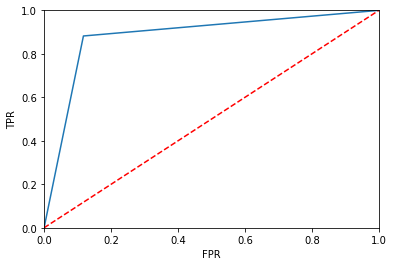

In [10]:
lR = LogisticRegression()
lR.fit(x_train, y_train)
y_pred = lR.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print('Accuracy: {}', accuracy)
print('AUC: {}', auc)
plt.plot(fpr, tpr, label='AUC')
plt.plot([0, 1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [11]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [12]:
def clean_text(text, stemming=True):
    text = text.lower()
    text = text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/^]', ' ', text)
    text = text.split()
    
    stops = set(nltk.corpus.stopwords.words("english"))
    text = [w for w in text if not w in stops]
    if stemming:
        text = [ps.stem(word) for word in text]
    else:
        text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [13]:
stemmed = []
lemmatized = []
for text in reviews.text:
    stemmed.append(clean_text(text, True))
    lemmatized.append(clean_text(text, False))

In [14]:
reviews.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [15]:
stemmed[:5]

['stune even non gamer sound track beauti paint seneri mind well would recomend even peopl hate video game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen',
 "best soundtrack ever anyth i'm read lot review say best 'game soundtrack' figur i'd write review disagre bit opinino yasunori mitsuda' ultim masterpiec music timeless i'm listen year beauti simpli refus fade price tag pretti stagger must say go buy cd much money one feel would worth everi penni",
 "amaz soundtrack favorit music time hand intens sad prison fate mean play game hope distant promis girl stole star import inspir person throughout teen year higher energi track like chrono cross ~ time' scar~ time dreamwatch chronomantiqu indefin remenisc chrono trigger absolut superb well soundtrack amaz music probabl best composer' work heard xenogear soundtrack can't say sure even never play game would worth twice price buy w

In [16]:
lemmatized[:5]

['stuning even non gamer sound track beautiful paint senery mind well would recomend even people hate video game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen',
 "best soundtrack ever anything i'm reading lot review saying best 'game soundtrack' figured i'd write review disagree bit opinino yasunori mitsuda's ultimate masterpiece music timeless i'm listening year beauty simply refuse fade price tag pretty staggering must say going buy cd much money one feel would worth every penny",
 "amazing soundtrack favorite music time hand intense sadness prisoner fate mean played game hope distant promise girl stole star important inspiration personally throughout teen year higher energy track like chrono cross ~ time's scar~ time dreamwatch chronomantique indefinably remeniscent chrono trigger absolutely superb well soundtrack amazing music probably best composer's work hear

In [17]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(stemmed)


tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, reviews.label, test_size=0.3)

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: {} 0.8493333333333334
AUC: {} 0.8493139785510228


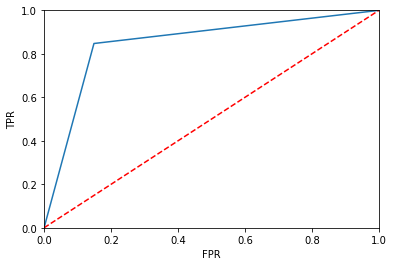

In [18]:
lR = LogisticRegression()
lR.fit(x_train, y_train)
y_pred = lR.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print('Accuracy: {}', accuracy)
print('AUC: {}', auc)
plt.plot(fpr, tpr, label='AUC')
plt.plot([0, 1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(lemmatized)


tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, reviews.label, test_size=0.3)